# **PROJET BIO-INFO : L'impact de la hausse des températures sur la puissance des ouragans**

# Membres du groupe:

- Anderson TESS
- Fiacre MITOKPE
- Kenny RUFFINE
- Gneneman Stéphane Jean-Baptiste KONÉ 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import folium
import requests
from bs4 import BeautifulSoup
import xarray as xr
import tempfile
import os
!pip install folium

In [2]:
#Dataset sur les cyclones (certaines lignes ont plus de virgules, c'est pourquoi on "skip" dans les bad_lines)
df2 = pd.read_csv("storms (1).csv", sep=",", engine="python", on_bad_lines="skip")
df2 = df2.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter", "pressure"]) # colonnes qu'on veut supprimer
df2 = df2[df2["status"] == "hurricane"] # on regarde que les ouragans pour le moment



# On garde que les moments min et max du vent pour chaque ouragan
df2["wind"] = pd.to_numeric(df2["wind"], errors="coerce")


In [3]:
# MAX WIND SPEEDS
df2_max = df2.loc[df2.groupby(["name","year"])["wind"].idxmax()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_max = df2_max.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_max = df2_max.reset_index(drop=True)

# on affiche le dataset
df2_max

,name,year,month,day,hour,lat,long,status,category,wind
0,Eloise,1975,9,23,12,30.2,-86.3,hurricane,3.0,110
1,Doris,1975,9,2,6,36.4,-44.5,hurricane,2.0,95
2,Caroline,1975,8,31,0,24.0,-97.0,hurricane,3.0,100
3,Faye,1975,9,27,0,32.7,-64.2,hurricane,2.0,90
4,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75
...,...,...,...,...,...,...,...,...,...,...
314,Fiona,2022,9,21,6,23.5,-71.8,hurricane,4.0,120
315,Martin,2022,11,2,18,36.1,-48.9,hurricane,1.0,75
316,Danielle,2022,9,4,18,38.4,-45.2,hurricane,1.0,75
317,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65


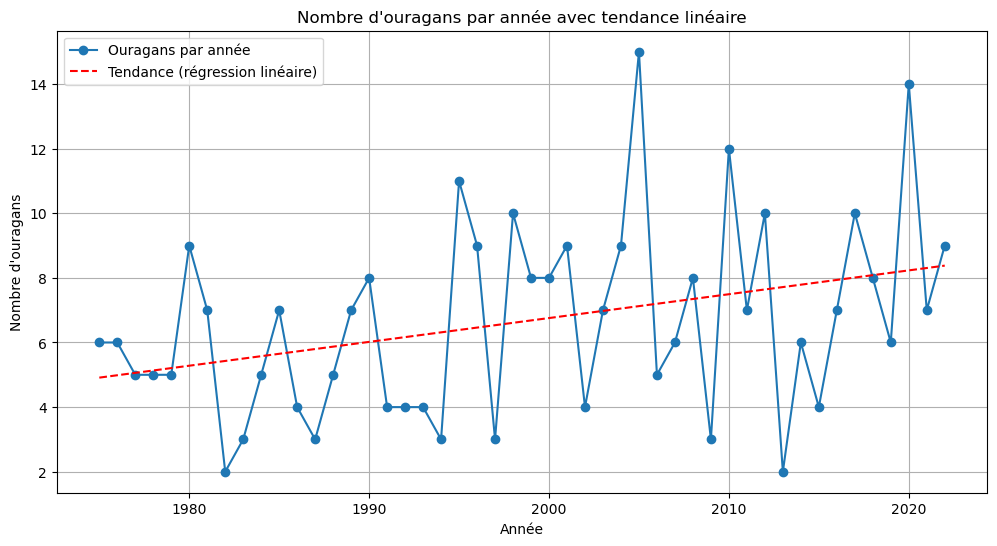

In [11]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_max["year"].value_counts().sort_index()

# Conversion des données en tableaux numpy
x = hurricanes_per_year.index.values  # Années
y = hurricanes_per_year.values        # Nombre d'ouragans

# Ajustement d'une régression linéaire (droite de tendance)
coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale

# Générer les valeurs prédites pour tracer la droite
x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
y_smooth = linear_trend(x_smooth)

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")

# Ajout de la droite de tendance
plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")

# Ajout des labels et du titre
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année avec tendance linéaire")
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

In [13]:

# MIN WIND SPEEDS
df2_min = df2.loc[df2.groupby(["name","year"])["wind"].idxmin()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_min = df2_min.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_min = df2_min.reset_index(drop=True)

# on affiche le dataset
df2_min


,name,year,month,day,hour,lat,long,status,category,wind
0,Eloise,1975,9,16,18,19.5,-68.4,hurricane,1.0,65
1,Doris,1975,8,31,0,34.9,-46.3,hurricane,1.0,65
2,Caroline,1975,8,30,0,23.3,-94.2,hurricane,1.0,65
3,Faye,1975,9,26,0,26.5,-60.0,hurricane,1.0,65
4,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65
...,...,...,...,...,...,...,...,...,...,...
314,Fiona,2022,9,18,12,17.2,-66.2,hurricane,1.0,65
315,Martin,2022,11,2,12,35.1,-50.9,hurricane,1.0,65
316,Danielle,2022,9,2,12,37.8,-43.6,hurricane,1.0,65
317,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65


In [ ]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_min["year"].value_counts().sort_index()

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(hurricanes_per_year.index, hurricanes_per_year.values, marker='o', linestyle='-')
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année")
plt.grid(True)
plt.show()

In [31]:

def get_hurricane_year_by_index(df, index):
    """
    retourne une seule ligne du dataset en fonction de l'indice donné en paramètre.

    Paramètres:
    df (DataFrame): dataset des ouragans.
    index (int): indice de la ligne à recupérer.

    Returns:
    str : Une str Pandas contenant l'année, le mois, le jour, la latitude, la longitude et la catégorie, 
            ou un message d'erreur si l'index dépasse la taille du dataset.
    """

    required_columns = {"year"}

    if not required_columns.issubset(df.columns):
        return "Error: The dataset does not contain all the required columns."

    if index < 0 or index >= len(df):
        return "Error: Index out of range."

    return int(df.loc[index, ["year"]])

print("\n")
index = 43 #1982 
index2 = 102 #1995 
index3 = 162 #2002
index4 = 190 #2005 
index5 = 228 #2010 
index6 = 247 #2013 
index7 = 300 #2020 
hurricane_year1 = get_hurricane_year_by_index(df2_max, index)
hurricane_year2 = get_hurricane_year_by_index(df2_max, index2)
hurricane_year3 = get_hurricane_year_by_index(df2_max, index3)
hurricane_year4 = get_hurricane_year_by_index(df2_max, index4)
hurricane_year5 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year6 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year7 = get_hurricane_year_by_index(df2_max, index7)
print(hurricane_year1)
print("\n")
print(hurricane_year2)
print("\n")
print(hurricane_year3)
print("\n")
print(hurricane_year4)
print("\n")
print(hurricane_year5)
print("\n")
print(hurricane_year6)
print("\n")
print(hurricane_year7)
print("\n")






1982


1995


2002


2005


2010


2010


2020




/var/folders/jf/ky5d7g9j46b3lxr7qf66yw0r0000gn/T/ipykernel_58002/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/jf/ky5d7g9j46b3lxr7qf66yw0r0000gn/T/ipykernel_58002/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/jf/ky5d7g9j46b3lxr7qf66yw0r0000gn/T/ipykernel_58002/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/jf/ky5d7g9j46b3lxr7qf66yw0r0000gn/T/ipykernel_58002/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instea

In [33]:


def plot_hurricane_on_map_with_category(df):
    """
    Affiche les positions des cyclones (latitude, longitude) sur une carte interactive avec une icône
    correspondant à la catégorie de chaque ouragan.
    
    Parameters:
    df (DataFrame): Le dataset des cyclones avec des colonnes 'lat', 'long' et 'category'.
    
    Returns:
    folium.Map: Carte interactive affichant les cyclones avec des icônes basées sur leur catégorie.
    """
    # Créer une carte centrée autour d'un point par défaut (ici, centre de l'océan Atlantique)
    hurricane_map = folium.Map(location=[20, -50], zoom_start=3)

    # Vérifier que les colonnes nécessaires existent dans le DataFrame
    if 'lat' in df.columns and 'long' in df.columns and 'category' in df.columns:
        # Dictionnaire pour associer une couleur à chaque catégorie
        category_colors = {
            1: 'blue',     # Catégorie 1 
            2: 'green',    # Catégorie 2
            3: 'orange',   # Catégorie 3 
            4: 'red',   # Catégorie 4 
            5: 'black'       # Catégorie 5  
        }
        
        # Ajouter un marqueur pour chaque cyclone en fonction de la latitude et la longitude)
        for index, row in df.iterrows():
            category = row['category']
            color = category_colors.get(category, 'gray')  # Utiliser 'gray' par défaut si la catégorie est inconnue
            
            folium.Marker(
                location=[row['lat'], row['long']],
                popup=f"Name : {row['name']}, Year: {row['year']}, Month: {row['month']}, Day: {row['day']}, Category: {category}",
                icon=folium.Icon(color=color, icon='info-sign')
            ).add_to(hurricane_map)
    else:
        print("Erreur : Les colonnes 'lat', 'long' et 'category' sont nécessaires dans le DataFrame.")
    
    
    return hurricane_map


hurricane_map = plot_hurricane_on_map_with_category(df2_max)
hurricane_map



    

In [35]:
#La fonction pour afficher l'évolution de la forces des vents
##Pour chaque année, on calcule la moyenne de la force des vents
mean_of_wind_per_year = df2.groupby('year')['wind'].mean().reset_index()
mean_of_wind_per_year


,year,wind
0,1975,79.329268
1,1976,79.326923
2,1977,80.384615
3,1978,86.976744
4,1979,88.372093
5,1980,87.516340
6,1981,82.444444
7,1982,87.391304
8,1983,75.312500
9,1984,75.472973


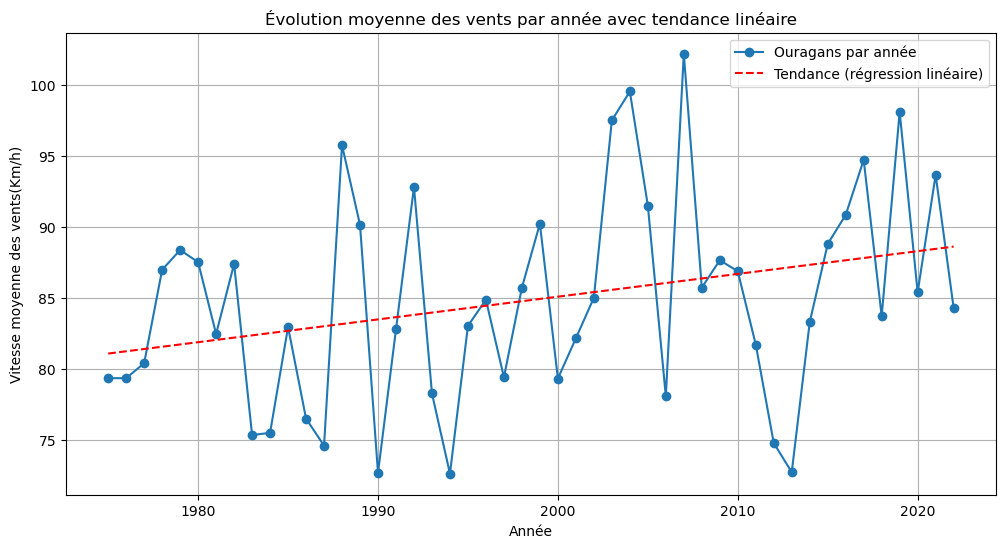

In [37]:

def affichage_moy_vents(df):
    #conversion des données en tableaux numpy
    x = mean_of_wind_per_year['year']  # Années
    y = mean_of_wind_per_year['wind']        # Vent
    
    #ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    #générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    #tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")
    
    
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    
    plt.xlabel("Année")
    plt.ylabel("Vitesse moyenne des vents(Km/h)")
    plt.legend()
    plt.title("Évolution moyenne des vents par année avec tendance linéaire")
    plt.grid(True)
    
    # Affichage du graphique
    plt.show()

affichage_moy_vents(mean_of_wind_per_year)

In [41]:
#La fonction pour afficher l'évolution de la catégorie des ouragans
##Pour chaque année, on calcule la moyenne de la catégorie des ouragans
mean_of_category_per_year = df2.groupby('year')['category'].mean().reset_index()
mean_of_category_per_year

,year,category
0,1975,1.487805
1,1976,1.480769
2,1977,1.576923
3,1978,1.906977
4,1979,2.000000
5,1980,1.928105
6,1981,1.644444
7,1982,1.869565
8,1983,1.375000
9,1984,1.270270


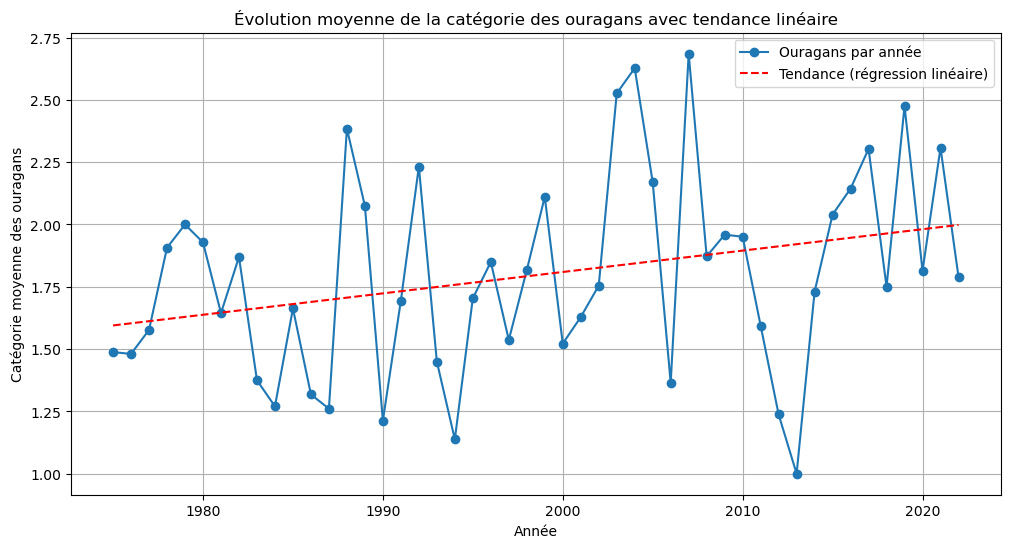

In [43]:

def affiche_moy_cat(df):
    #conversion des données en tableaux numpy
    x = mean_of_category_per_year['year']  # Années
    y = mean_of_category_per_year['category']        # Vent
    
    #ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    #générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    #tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")
    
    #droite de tendance
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    plt.xlabel("Année")
    plt.ylabel("Catégorie moyenne des ouragans")
    plt.legend()
    plt.title("Évolution moyenne de la catégorie des ouragans avec tendance linéaire")
    plt.grid(True)
    

    plt.show()

affiche_moy_cat(mean_of_category_per_year)

In [45]:
#Dataset sur les cyclones (certaines lignes ont plus de virgules, c'est pourquoi on "skip" dans les bad_lines)
df2 = pd.read_csv("storms.csv", sep=",", engine="python", on_bad_lines="skip")
df2 = df2.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter"]) # colonnes qu'on veut supprimer
df2 = df2[df2["status"] == "hurricane"] # on regarde que les ouragans pour le moment

# On garde que les moments min et max du vent pour chaque ouragan
df2["wind"] = pd.to_numeric(df2["wind"], errors="coerce")

# MAX WIND SPEEDS
df2_max = df2.loc[df2.groupby("name")["wind"].idxmax()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_max = df2_max.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_max = df2_max.reset_index(drop=True)

# on affiche le dataset
df2_max

KeyError: "['tropicalstorm_force_diameter', 'hurricane_force_diameter'] not found in axis"

In [ ]:

# MIN WIND SPEEDS
df2_min = df2.loc[df2.groupby("name")["wind"].idxmin()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_min = df2_min.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_min = df2_min.reset_index(drop=True)

# on affiche le dataset
df2_min


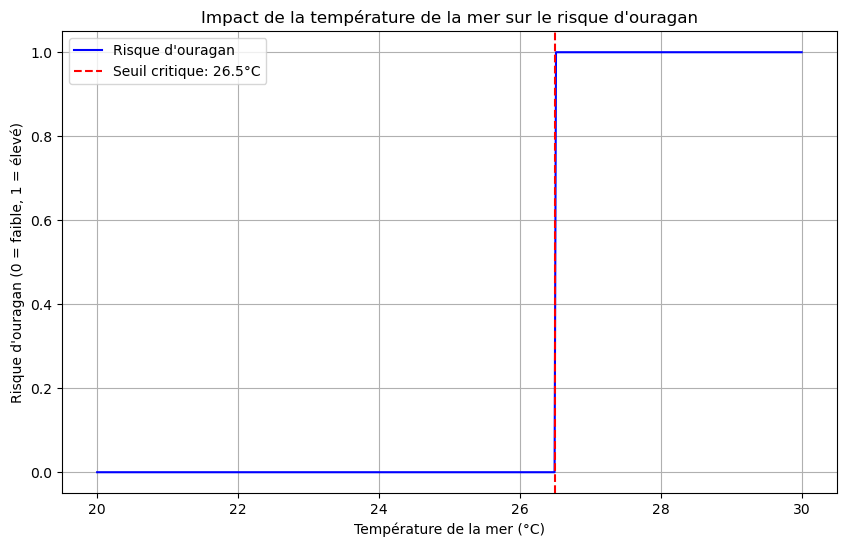

In [24]:
# Générer une plage de températures de la mer allant de 20°C à 30°C
temperatures = np.linspace(20, 30, 500)

# On considère que pour T < 26.5°C, le risque est faible (0)
# et pour T >= 26.5°C, le risque devient élevé (1)
risque = np.where(temperatures >= 26.5, 1, 0)

# Création de la figure
plt.figure(figsize=(10, 6))

# Tracé de la courbe du risque en fonction de la température
plt.plot(temperatures, risque, label="Risque d'ouragan", color='blue')

# Ajout d'une ligne verticale pour marquer le seuil critique de 26.5°C
plt.axvline(26.5, color='red', linestyle='--', label="Seuil critique: 26.5°C")

# Étiquettes et titre
plt.xlabel("Température de la mer (°C)")
plt.ylabel("Risque d'ouragan (0 = faible, 1 = élevé)")
plt.title("Impact de la température de la mer sur le risque d'ouragan")

# Affichage de la légende et de la grille
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

In [25]:

def verify_files():
    # Vérification du fichier CSV
    csv_file = "storms.csv"
    if os.path.exists(csv_file):
        print(f"Le fichier CSV '{csv_file}' a été trouvé.")
        # Affichage rapide des premières lignes
        df = pd.read_csv(csv_file)
        print("Aperçu du fichier CSV :")
        print(df.head())
    else:
        print(f"Le fichier CSV '{csv_file}' n'a pas été trouvé.")
    
    # Vérification du fichier NetCDF pour 1981
    nc_file = "sst.day.mean.2002.nc"
    if os.path.exists(nc_file):
        print(f"\nLe fichier NetCDF '{nc_file}' a été trouvé.")
        ds = xr.open_dataset(nc_file)
        print("Variables disponibles dans le fichier NetCDF :", list(ds.data_vars))
        print("Coordonnées disponibles :", list(ds.coords))
    else:
        print(f"Le fichier NetCDF '{nc_file}' n'a pas été trouvé.")

if __name__ == "__main__":
    verify_files()


Le fichier CSV 'storms.csv' a été trouvé.
Aperçu du fichier CSV :
  name  year  month  day  hour   lat  long               status  category  \
0  Amy  1975      6   27     0  27.5 -79.0  tropical depression       NaN   
1  Amy  1975      6   27     6  28.5 -79.0  tropical depression       NaN   
2  Amy  1975      6   27    12  29.5 -79.0  tropical depression       NaN   
3  Amy  1975      6   27    18  30.5 -79.0  tropical depression       NaN   
4  Amy  1975      6   28     0  31.5 -78.8  tropical depression       NaN   

   wind  pressure  tropicalstorm_force_diameter  hurricane_force_diameter  
0    25      1013                           NaN                       NaN  
1    25      1013                           NaN                       NaN  
2    25      1013                           NaN                       NaN  
3    25      1013                           NaN                       NaN  
4    25      1012                           NaN                       NaN  

Le fichier Net

In [26]:

def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') à l'aide des coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    # (le champ 'hour' est omis ici car le NetCDF contient des moyennes journalières)
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst') 
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # la colonne s'appelle 'long' dans le CSV et 'lon' dans le NetCDF
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            # Si la sélection échoue (par exemple, si l'événement est en dehors du domaine du NetCDF), retourner None
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame des tempêtes
    storms_year["sst"] = sst_values
    
    return storms_year

# Exemple d'utilisation
if __name__ == "__main__":
    annee = 1981  # Remplacer par l'année souhaitée
    result_df = get_sst_for_year(annee)
    print(result_df.head())


        name  year  month  day  hour   lat  long               status  \
1267  Arlene  1981      5    6    18  18.4 -83.6  tropical depression   
1268  Arlene  1981      5    7     0  18.4 -82.7  tropical depression   
1269  Arlene  1981      5    7     6  18.6 -81.7  tropical depression   
1270  Arlene  1981      5    7    12  19.0 -80.6       tropical storm   
1271  Arlene  1981      5    7    18  19.6 -79.7       tropical storm   

      category  wind  pressure  tropicalstorm_force_diameter  \
1267       NaN    30      1006                           NaN   
1268       NaN    30      1006                           NaN   
1269       NaN    30      1005                           NaN   
1270       NaN    35      1003                           NaN   
1271       NaN    40      1000                           NaN   

      hurricane_force_diameter   datetime  sst  
1267                       NaN 1981-05-06  NaN  
1268                       NaN 1981-05-07  NaN  
1269                       Na

In [116]:
def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') en utilisant les coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst')
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # dans le CSV la colonne s'appelle 'long' et dans le NetCDF 'lon'
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame
    storms_year["sst"] = sst_values
    
    return storms_year

def plot_sst_for_year(year):
    """
    Pour une année donnée, cette fonction récupère les données de tempête avec leur SST associée
    et affiche un graphique avec la date sur l'axe x et la température (SST) sur l'axe y.
    """
    # Récupération des données
    df = get_sst_for_year(year)
    
    # On élimine les événements sans donnée SST
    df = df[df['sst'].notnull()]
    
    # Création du graphique
    plt.figure(figsize=(12, 6))
    plt.scatter(df['datetime'], df['sst'], color='blue', label='Température SST')
    plt.xlabel("Date")
    plt.ylabel("Température de surface de la mer (SST)")
    plt.title(f"Température de surface de la mer lors des ouragans en {year}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    annee =hurricane_year3  # Remplacer par l'année souhaitée
    plot_sst_for_year(annee)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kennyruffine/Desktop/cours MIAGE/BIO_Info/projet/sst.day.mean.2002.nc'